In [1]:
# # Display plots inline and change default figure size
# %matplotlib inline

# Package imports
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from pandas_datareader import data as datard
from datetime import datetime, timedelta
import yfinance
import matplotlib.ticker as mticker
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.signal import argrelextrema
from mplfinance.original_flavor import candlestick_ohlc


In [2]:
from statsmodels.nonparametric.kernel_regression import KernelReg

def find_local_extreme(data):
    df = data.copy()
    del df['High']
    del df['Low']
    del df['Open']
    prices = df.copy()
    prices = prices.reset_index()
    prices.columns = ['date', 'price']
    prices = prices['price']
    
    kr = KernelReg([prices.values], [prices.index.to_numpy()], var_type='c')
    f = kr.fit([prices.index])

    smooth_prices = pd.Series(data=f[0], index=df.index)

    # Use smoothed prices to determine local minima and maxima
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    smooth_local_max = argrelextrema(smooth_prices.values, np.greater , order = 5)[0]
    smooth_local_min = argrelextrema(smooth_prices.values, np.less , order = 5)[0]
    local_max_min = np.sort(
        np.concatenate([smooth_local_max, smooth_local_min]))
    smooth_extrema = smooth_prices.loc[local_max_min]

    # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
    price_local_max_dt = []
    for i in smooth_local_max:
        if (i > 1) and (i < len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

    price_local_min_dt = []
    for i in smooth_local_min:
        if (i > 1) and (i < len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

    maxima = pd.Series(prices.loc[price_local_max_dt])
    minima = pd.Series(prices.loc[price_local_min_dt])
    extrema = pd.concat([maxima, minima]).sort_index()

    # Return series for each with bar as index
    return extrema, prices, smooth_extrema, smooth_prices


In [3]:
from collections import defaultdict
def find_patterns(extrema, max_bars=35):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        patterns: patterns as a defaultdict list of tuples
        containing the start and end bar of the pattern
    """
    patterns = defaultdict(list)

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)):
        window = extrema.iloc[i-5:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (max(e1, e3, e5) > min(e2, e4)):

            patterns['RBOT'].append((window.index[0], window.index[-1]))

    return patterns

In [4]:
def plot_window(prices, extrema, smooth_prices, smooth_extrema, ax=None):
    """
    Input: data from find_extrema
    Output: plots window for actual and smoothed prices and extrema
    """
    if ax is None:
        fig = plt.figure(figsize=[20,14])
        ax = fig.add_subplot(111)

    prices.plot(ax=ax, color='dodgerblue')
    ax.scatter(extrema.index, extrema.values, color='red')
    smooth_prices.plot(ax=ax, color='lightgrey')
    ax.scatter(smooth_extrema.index, smooth_extrema.values, color='lightgrey')

In [5]:
#plot_window(prices, extrema, smooth_prices, smooth_extrema)

In [6]:
# convert the price data in to actual candlestick parameters. Each candle has 4 parameters
# Open	High Low	Close -< conversion_array
# Size of the body measured by pips
# Size of the upper wicks measured by pips
# Size of the lower wicks measured by pips
# Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)


#Handle
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000, 4)
    candlestick_data[2]=round(round(wicks_down,5)*10000, 4)
    candlestick_data[3]=round(round(body_size,5)*10000, 4)

    return candlestick_data

In [7]:
def pre_processing(df):
    extrema, prices, smooth_extrema, smooth_prices = find_local_extreme(stock_df)
    patterns = find_patterns(extrema)
    cor_arr = []
    for name, pattern_periods in patterns.items():
        if name=='TBOT':    
            for start, end in pattern_periods:
                x = prices.index[start-1]
                y = prices.index[end+1]
                if (y-x < 40):
                    gap = 40 - y + x 
                    mid = int(gap / 2)
                    x = x - mid
                    y = y + gap - mid
                    cor_arr.append([x,y])
            
    X_raw_tmp = [] #Array for actual data
    X_tmp = [] #Array for converted data
    Y_tmp = [] #Array for prediction based on the condition whether the mean close value of next two week is higher than current close value

    for row in cor_arr:
        tmp = []
        mean = []
        prediction = 0
        X_raw_tmp.append(df.values[row[0] : row[1]]) # append raw value

        for idx in range(row[0] , row[1]):
            converted_data = ohlc_to_candlestick(df.values[idx])
            tmp.append(converted_data) # convert data to cds 

        for idx in range(row[1], row[1] + 14):
            mean.append(df.values[idx][3])

        X_tmp.append(tmp)
        if (np.mean(mean) > df.values[row[1]][3]):
            prediction = 1
        Y_tmp.append(prediction)

    X_tmp = np.asarray(X_tmp)
    X_raw_tmp = np.asarray(X_raw_tmp)
    Y_tmp = np.asarray(Y_tmp)

    return X_tmp, Y_tmp, X_raw_tmp

X  = np.empty((0, 40 ,4))
Y = np.empty((0))
X_raw = np.empty((0, 40 ,4))


In [8]:
X  = np.empty((0, 40 ,4))
Y = np.empty((0))
X_raw = np.empty((0, 40 ,4))

In [9]:
stocks = ['AAPL' , 'MSFT' , 'AMD' , 'FB' , 'AMD' , 'FB' , 'AMZN']
# , , 'ADSK' , 'ANSS' ,  'AVGO' , 'AZN' , 'FISV' , 'GILD' , 'KHC' , 'NFLX' , 'OKTA' , 'REGN
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 300  * 30)

for stock in stocks:
  stock_df = yfinance.download(stock , startDate , endDate  )
  del stock_df['Volume']
  del stock_df['Adj Close']
  X1 , Y1 , X_raw1 = pre_processing(stock_df)
  X = np.concatenate((X, X1) , axis= 0)
  Y = np.concatenate((Y, Y1) , axis= 0)
  X_raw = np.concatenate((X_raw, X_raw1) , axis= 0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
X.shape

(153, 40, 4)

In [11]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(layers.LSTM(units = 25,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(layers.LSTM(units = 50))
model.add(Dropout(0.1))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [12]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5 , shuffle = False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5 , shuffle = False)
X_train_raw, X_val_and_test_raw = train_test_split(X_raw, test_size=0.5 , shuffle = False )
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5 , shuffle = False)


In [13]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=20)

In [14]:
history = model.fit(X_train, Y_train, epochs= 500 , validation_data=(X_val, Y_val) , callbacks=[model_checkpoint , early_stopping])

Epoch 1/500
1/3 [=========>....................] - ETA: 6s - loss: 0.6769 - acc: 0.5625

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 11s 4s/step - loss: 0.7102 - acc: 0.4737 - val_loss: 0.6976 - val_acc: 0.4737
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6591 - acc: 0.6250

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.6939 - acc: 0.5526 - val_loss: 0.6908 - val_acc: 0.5526
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6989 - acc: 0.5625

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 4s/step - loss: 0.6943 - acc: 0.5000 - val_loss: 0.6839 - val_acc: 0.5526
Epoch 4/500
3/3 [==============================] - 0s 29ms/step - loss: 0.6930 - acc: 0.4868 - val_loss: 0.7041 - val_acc: 0.4737
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6918 - acc: 0.5658 - val_loss: 0.7052 - val_acc: 0.4737
Epoch 6/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6997 - acc: 0.5625

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 4s/step - loss: 0.6874 - acc: 0.5395 - val_loss: 0.6809 - val_acc: 0.6316
Epoch 7/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6893 - acc: 0.5312

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 4s/step - loss: 0.6888 - acc: 0.5263 - val_loss: 0.6769 - val_acc: 0.5789
Epoch 8/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6729 - acc: 0.6250

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.7000 - acc: 0.5132 - val_loss: 0.6736 - val_acc: 0.6579
Epoch 9/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6697 - acc: 0.7188

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.6754 - acc: 0.6447 - val_loss: 0.6724 - val_acc: 0.6316
Epoch 10/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6691 - acc: 0.5921 - val_loss: 0.6777 - val_acc: 0.5000
Epoch 11/500
3/3 [==============================] - ETA: 0s - loss: 0.6820 - acc: 0.5526

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 4s/step - loss: 0.6820 - acc: 0.5526 - val_loss: 0.6699 - val_acc: 0.6053
Epoch 12/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6831 - acc: 0.5658 - val_loss: 0.6741 - val_acc: 0.5526
Epoch 13/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6817 - acc: 0.5921 - val_loss: 0.6769 - val_acc: 0.6316
Epoch 14/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6580 - acc: 0.5625

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.6702 - acc: 0.6053 - val_loss: 0.6628 - val_acc: 0.6053
Epoch 15/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6600 - acc: 0.6447 - val_loss: 0.6678 - val_acc: 0.5789
Epoch 16/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6233 - acc: 0.6875

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.6627 - acc: 0.5921 - val_loss: 0.6596 - val_acc: 0.5526
Epoch 17/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6641 - acc: 0.6875

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.6687 - acc: 0.5789 - val_loss: 0.6576 - val_acc: 0.5526
Epoch 18/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6680 - acc: 0.6562

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 4s/step - loss: 0.6589 - acc: 0.6184 - val_loss: 0.6509 - val_acc: 0.6316
Epoch 19/500
3/3 [==============================] - 0s 45ms/step - loss: 0.6564 - acc: 0.5921 - val_loss: 0.6607 - val_acc: 0.5789
Epoch 20/500
3/3 [==============================] - 0s 48ms/step - loss: 0.6526 - acc: 0.6184 - val_loss: 0.6531 - val_acc: 0.6053
Epoch 21/500
3/3 [==============================] - 0s 43ms/step - loss: 0.6447 - acc: 0.6842 - val_loss: 0.6624 - val_acc: 0.5000
Epoch 22/500
3/3 [==============================] - 0s 46ms/step - loss: 0.6468 - acc: 0.5658 - val_loss: 0.6512 - val_acc: 0.6316
Epoch 23/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6425 - acc: 0.6250

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.6272 - acc: 0.6974 - val_loss: 0.6402 - val_acc: 0.6842
Epoch 24/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6419 - acc: 0.6842 - val_loss: 0.6700 - val_acc: 0.5263
Epoch 25/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6477 - acc: 0.6053 - val_loss: 0.6434 - val_acc: 0.7105
Epoch 26/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6322 - acc: 0.6875

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 8s 4s/step - loss: 0.6179 - acc: 0.6842 - val_loss: 0.6194 - val_acc: 0.6579
Epoch 27/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6152 - acc: 0.7188

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 8s 4s/step - loss: 0.6212 - acc: 0.7105 - val_loss: 0.6136 - val_acc: 0.7105
Epoch 28/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6207 - acc: 0.6842 - val_loss: 0.6238 - val_acc: 0.6842
Epoch 29/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6351 - acc: 0.5938

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 8s 4s/step - loss: 0.6043 - acc: 0.6974 - val_loss: 0.6029 - val_acc: 0.7368
Epoch 30/500
1/3 [=========>....................] - ETA: 0s - loss: 0.6184 - acc: 0.6562

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.6103 - acc: 0.6711 - val_loss: 0.5917 - val_acc: 0.7368
Epoch 31/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5966 - acc: 0.6974 - val_loss: 0.5991 - val_acc: 0.7105
Epoch 32/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6031 - acc: 0.6974 - val_loss: 0.6292 - val_acc: 0.6053
Epoch 33/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5956 - acc: 0.6562

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 4s/step - loss: 0.5965 - acc: 0.6711 - val_loss: 0.5753 - val_acc: 0.7105
Epoch 34/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5687 - acc: 0.7368 - val_loss: 0.6081 - val_acc: 0.6053
Epoch 35/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5840 - acc: 0.7368 - val_loss: 0.5890 - val_acc: 0.6842
Epoch 36/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5266 - acc: 0.7188

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 8s 4s/step - loss: 0.5564 - acc: 0.7105 - val_loss: 0.5531 - val_acc: 0.7105
Epoch 37/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5417 - acc: 0.7500

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 8s 4s/step - loss: 0.5538 - acc: 0.7500 - val_loss: 0.5345 - val_acc: 0.7368
Epoch 38/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5274 - acc: 0.7500 - val_loss: 0.5494 - val_acc: 0.7105
Epoch 39/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4659 - acc: 0.9062

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.5044 - acc: 0.8026 - val_loss: 0.5313 - val_acc: 0.7632
Epoch 40/500
3/3 [==============================] - 0s 32ms/step - loss: 0.5122 - acc: 0.7632 - val_loss: 0.5338 - val_acc: 0.7632
Epoch 41/500
3/3 [==============================] - 0s 31ms/step - loss: 0.4754 - acc: 0.8553 - val_loss: 0.5419 - val_acc: 0.7632
Epoch 42/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4040 - acc: 0.8438

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.4899 - acc: 0.7237 - val_loss: 0.5140 - val_acc: 0.8158
Epoch 43/500
1/3 [=========>....................] - ETA: 0s - loss: 0.5049 - acc: 0.7500

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.4782 - acc: 0.7895 - val_loss: 0.5103 - val_acc: 0.8158
Epoch 44/500
3/3 [==============================] - 0s 35ms/step - loss: 0.4386 - acc: 0.8684 - val_loss: 0.5194 - val_acc: 0.6842
Epoch 45/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4093 - acc: 0.8125

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.4518 - acc: 0.7895 - val_loss: 0.5096 - val_acc: 0.7632
Epoch 46/500
1/3 [=========>....................] - ETA: 0s - loss: 0.4843 - acc: 0.7500

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.4080 - acc: 0.8289 - val_loss: 0.4343 - val_acc: 0.8684
Epoch 47/500
3/3 [==============================] - 0s 34ms/step - loss: 0.3554 - acc: 0.8816 - val_loss: 0.4541 - val_acc: 0.7632
Epoch 48/500
3/3 [==============================] - 0s 38ms/step - loss: 0.3526 - acc: 0.8816 - val_loss: 0.4489 - val_acc: 0.8158
Epoch 49/500
3/3 [==============================] - 0s 34ms/step - loss: 0.3985 - acc: 0.8421 - val_loss: 0.5070 - val_acc: 0.8158
Epoch 50/500
3/3 [==============================] - 0s 29ms/step - loss: 0.3336 - acc: 0.9079 - val_loss: 0.4576 - val_acc: 0.7368
Epoch 51/500
3/3 [==============================] - 0s 29ms/step - loss: 0.3424 - acc: 0.8816 - val_loss: 0.6856 - val_acc: 0.6579
Epoch 52/500
3/3 [==============================] - 0s 33ms/step - loss: 0.4542 - acc: 0.7500 - val_loss: 0.4544 - val_acc: 0.7895
Epoch 53/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3301 - acc: 0.8750

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 5s 3s/step - loss: 0.3410 - acc: 0.8684 - val_loss: 0.4338 - val_acc: 0.8158
Epoch 54/500
3/3 [==============================] - 0s 31ms/step - loss: 0.3126 - acc: 0.9079 - val_loss: 0.4511 - val_acc: 0.8158
Epoch 55/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2196 - acc: 0.9375

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.3002 - acc: 0.8684 - val_loss: 0.3867 - val_acc: 0.8421
Epoch 56/500
3/3 [==============================] - 0s 31ms/step - loss: 0.2952 - acc: 0.9079 - val_loss: 0.4125 - val_acc: 0.7632
Epoch 57/500
3/3 [==============================] - 0s 29ms/step - loss: 0.3133 - acc: 0.8947 - val_loss: 0.4193 - val_acc: 0.8158
Epoch 58/500
3/3 [==============================] - 0s 29ms/step - loss: 0.2643 - acc: 0.8947 - val_loss: 0.4181 - val_acc: 0.7895
Epoch 59/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3201 - acc: 0.8125

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 5s 3s/step - loss: 0.2670 - acc: 0.8816 - val_loss: 0.3553 - val_acc: 0.8421
Epoch 60/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2449 - acc: 0.8750

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.2457 - acc: 0.9079 - val_loss: 0.3279 - val_acc: 0.8684
Epoch 61/500
3/3 [==============================] - 0s 30ms/step - loss: 0.1963 - acc: 0.9342 - val_loss: 0.4027 - val_acc: 0.8684
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1950 - acc: 0.9375

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 5s 3s/step - loss: 0.1964 - acc: 0.9342 - val_loss: 0.3029 - val_acc: 0.9211
Epoch 63/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1432 - acc: 1.0000

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.1920 - acc: 0.9605 - val_loss: 0.3003 - val_acc: 0.8684
Epoch 64/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1906 - acc: 0.9375

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 6s 3s/step - loss: 0.1840 - acc: 0.9605 - val_loss: 0.2771 - val_acc: 0.8421
Epoch 65/500
3/3 [==============================] - 0s 36ms/step - loss: 0.1741 - acc: 0.9605 - val_loss: 0.2878 - val_acc: 0.8947
Epoch 66/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1194 - acc: 0.9737 - val_loss: 0.3864 - val_acc: 0.8684
Epoch 67/500
3/3 [==============================] - 0s 31ms/step - loss: 0.2755 - acc: 0.8816 - val_loss: 0.4085 - val_acc: 0.8421
Epoch 68/500
3/3 [==============================] - 0s 31ms/step - loss: 0.2504 - acc: 0.9211 - val_loss: 0.3051 - val_acc: 0.8947
Epoch 69/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1809 - acc: 0.9375

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 4s/step - loss: 0.1504 - acc: 0.9474 - val_loss: 0.2459 - val_acc: 0.9474
Epoch 70/500
3/3 [==============================] - 0s 37ms/step - loss: 0.1327 - acc: 0.9737 - val_loss: 0.3842 - val_acc: 0.8421
Epoch 71/500
3/3 [==============================] - 0s 32ms/step - loss: 0.2458 - acc: 0.8684 - val_loss: 0.2735 - val_acc: 0.8684
Epoch 72/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1715 - acc: 0.9474 - val_loss: 0.2704 - val_acc: 0.9211
Epoch 73/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1863 - acc: 0.9474 - val_loss: 0.4481 - val_acc: 0.8158
Epoch 74/500
3/3 [==============================] - 0s 31ms/step - loss: 0.2480 - acc: 0.9211 - val_loss: 0.2949 - val_acc: 0.9211
Epoch 75/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1433 - acc: 0.9868 - val_loss: 0.2764 - val_acc: 0.9211
Epoch 76/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1827 - acc: 0.9474 - va

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.1123 - acc: 0.9868 - val_loss: 0.2189 - val_acc: 0.9474
Epoch 79/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0760 - acc: 1.0000

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 7s 3s/step - loss: 0.0983 - acc: 0.9868 - val_loss: 0.2174 - val_acc: 0.9474
Epoch 80/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0770 - acc: 0.9868 - val_loss: 0.2436 - val_acc: 0.9211
Epoch 81/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0804 - acc: 0.9868 - val_loss: 0.2651 - val_acc: 0.9211
Epoch 82/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0932 - acc: 0.9688

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


3/3 [==============================] - 5s 3s/step - loss: 0.0687 - acc: 0.9868 - val_loss: 0.1681 - val_acc: 0.9474
Epoch 83/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0749 - acc: 0.9868 - val_loss: 0.2270 - val_acc: 0.9474
Epoch 84/500
3/3 [==============================] - 0s 30ms/step - loss: 0.2044 - acc: 0.9474 - val_loss: 0.3973 - val_acc: 0.8947
Epoch 85/500
3/3 [==============================] - 0s 28ms/step - loss: 0.1686 - acc: 0.9211 - val_loss: 0.2789 - val_acc: 0.8947
Epoch 86/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1052 - acc: 0.9605 - val_loss: 0.2608 - val_acc: 0.9211
Epoch 87/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0748 - acc: 0.9868 - val_loss: 0.3532 - val_acc: 0.8684
Epoch 88/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0741 - acc: 0.9868 - val_loss: 0.6324 - val_acc: 0.7632
Epoch 89/500
3/3 [==============================] - 0s 30ms/step - loss: 0.2893 - acc: 0.8421 - va

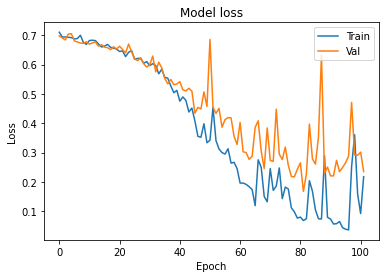

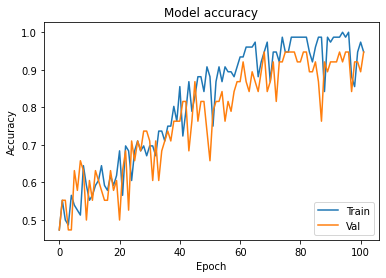

In [15]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 5ms/step - loss: 1.2057 - acc: 0.5641
Test accuracy: 0.5641025900840759


In [17]:
# Timestep = List of candles seqeuence
# Items = Candlestick
# Features = High, Low, Open, Close parametes
def graph_data_ohlc(dataset):
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date = range(len(closep))

    x = 0
    y = len(date)
    ohlc = []

    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x += 1

    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
        
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)


    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)    
    plt.show()

[0.01759866]
Correct trend is Bearish
Model prediction trend is Bearish
WON


C:\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


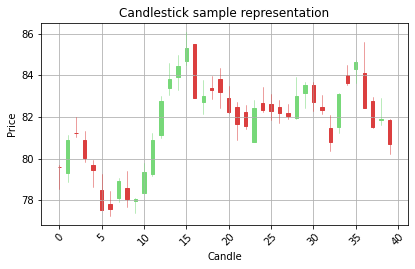

[0.9969282]
Correct trend is Bullish
Model prediction trend is Bullish
WON


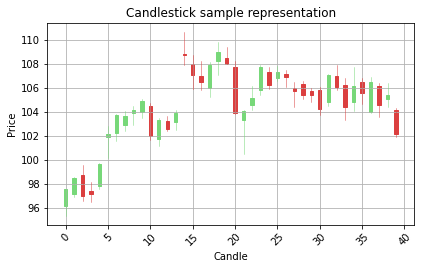

[0.01200572]
Correct trend is Bearish
Model prediction trend is Bearish
WON


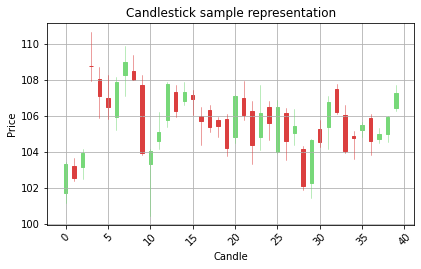

[0.0778757]
Correct trend is Bearish
Model prediction trend is Bearish
WON


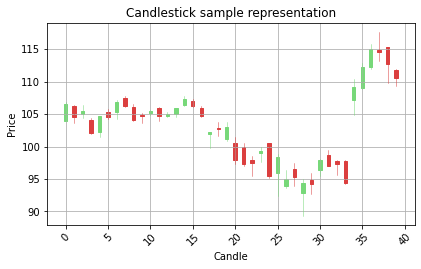

[0.9966688]
Correct trend is Bullish
Model prediction trend is Bullish
WON


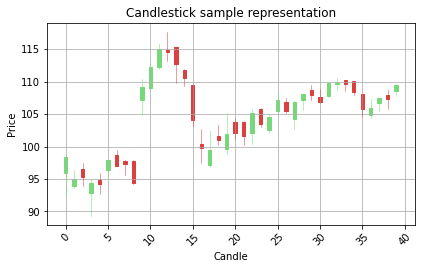

[0.9476422]
Correct trend is Bullish
Model prediction trend is Bullish
WON


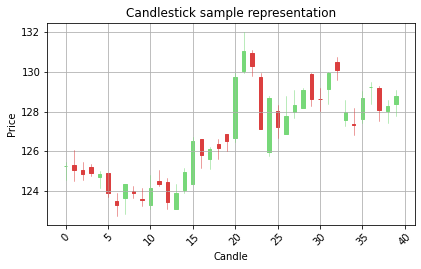

[0.99253416]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


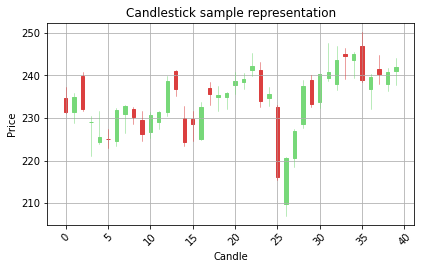

[0.906093]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


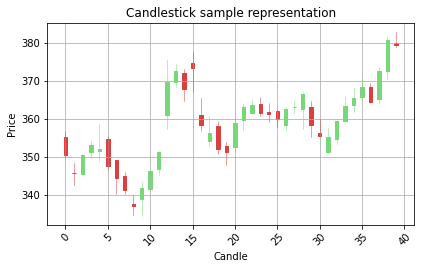

[0.70071924]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


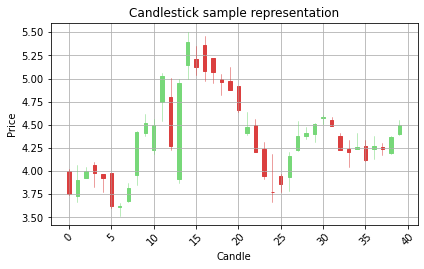

[0.9212816]
Correct trend is Bullish
Model prediction trend is Bullish
WON


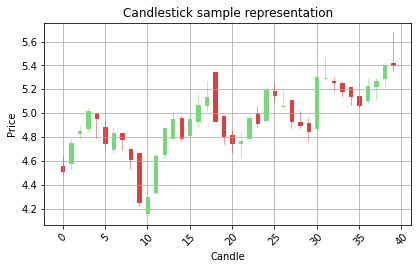

[0.15979731]
Correct trend is Bearish
Model prediction trend is Bearish
WON


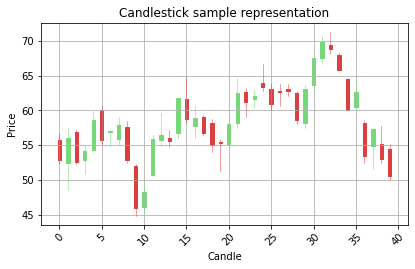

[0.5544113]
Correct trend is Bullish
Model prediction trend is Bullish
WON


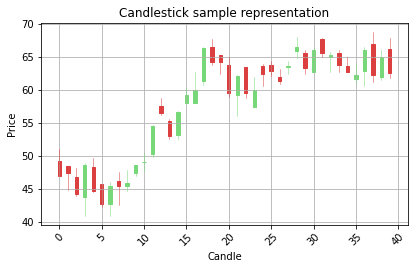

[0.00822625]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


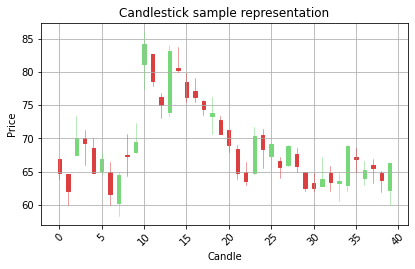

[0.03946805]
Correct trend is Bearish
Model prediction trend is Bearish
WON


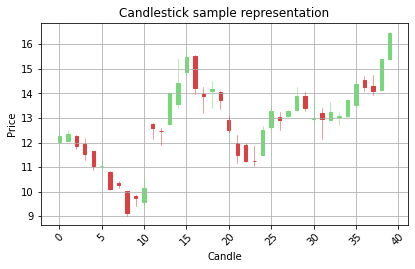

[0.92569035]
Correct trend is Bullish
Model prediction trend is Bullish
WON


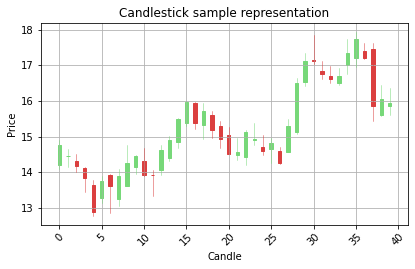

[0.09259328]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


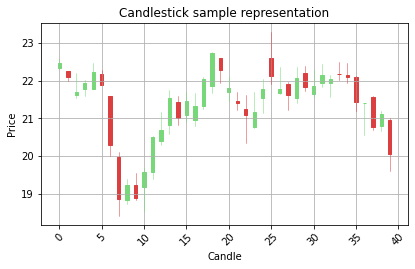

[0.24256924]
Correct trend is Bearish
Model prediction trend is Bearish
WON


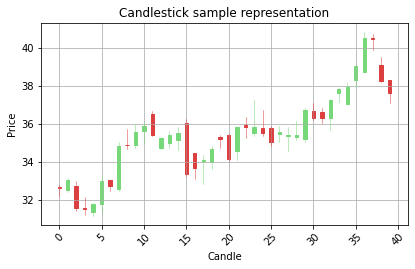

[0.73775864]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


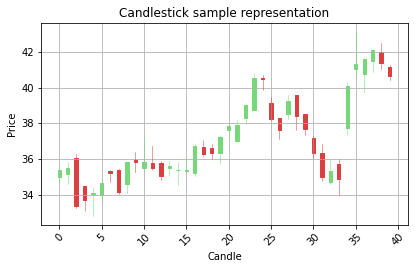

[0.7889931]
Correct trend is Bullish
Model prediction trend is Bullish
WON


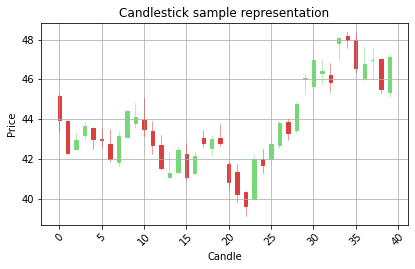

[0.11975208]
Correct trend is Bearish
Model prediction trend is Bearish
WON


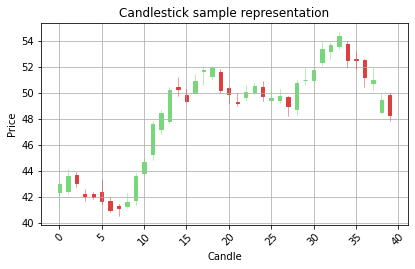

[0.00441647]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


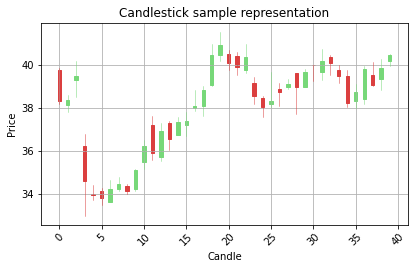

[0.9682437]
Correct trend is Bullish
Model prediction trend is Bullish
WON


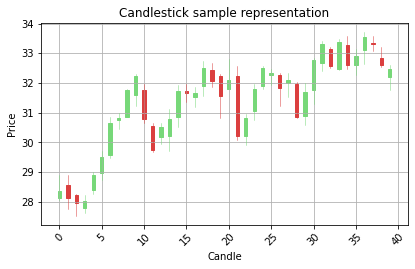

[0.67978483]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


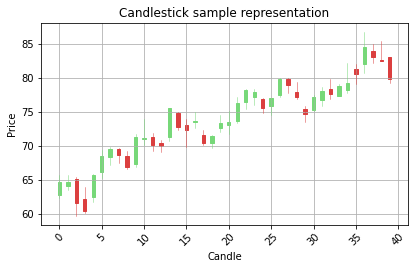

[0.942188]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


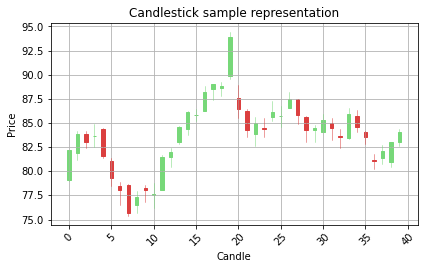

[0.56430936]
Correct trend is Bearish
Model prediction trend is Bullish
LOST


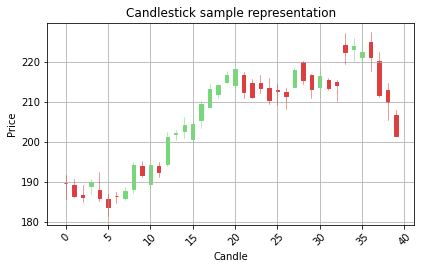

[0.06790924]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


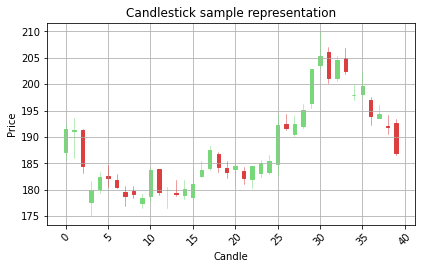

[0.3816434]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


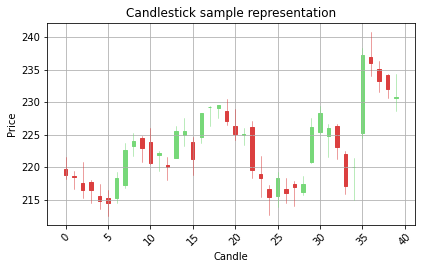

[0.04804057]
Correct trend is Bearish
Model prediction trend is Bearish
WON


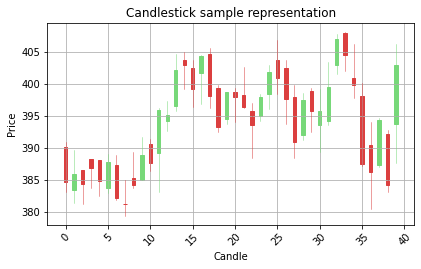

[0.62802136]
Correct trend is Bullish
Model prediction trend is Bullish
WON


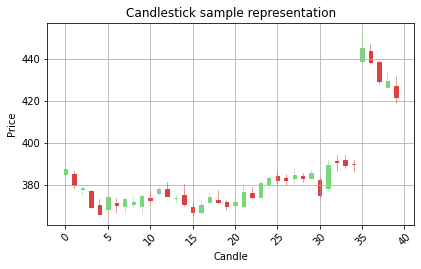

[0.20667541]
Correct trend is Bearish
Model prediction trend is Bearish
WON


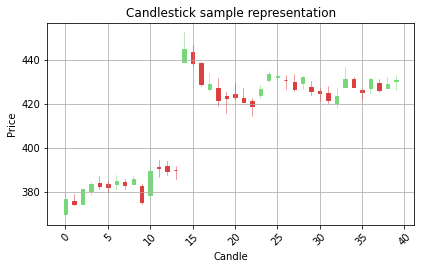

[0.2079688]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


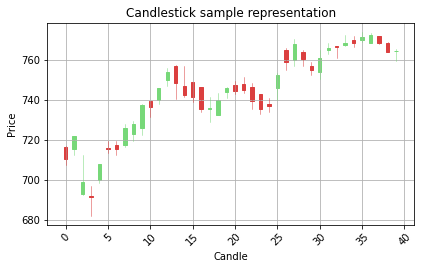

[0.10615477]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


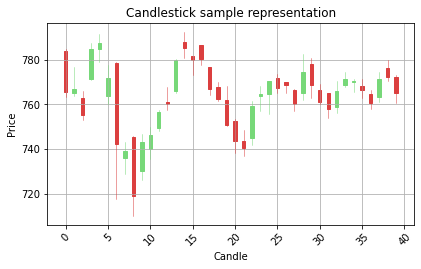

[0.00547048]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


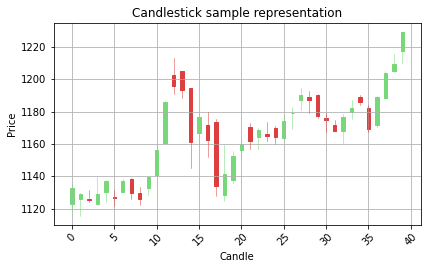

[0.69152224]
Correct trend is Bullish
Model prediction trend is Bullish
WON


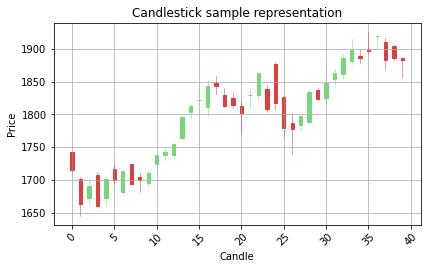

[0.5223116]
Correct trend is Bullish
Model prediction trend is Bullish
WON


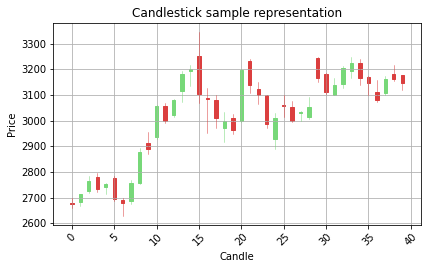

[0.49467143]
Correct trend is Bearish
Model prediction trend is Bearish
WON


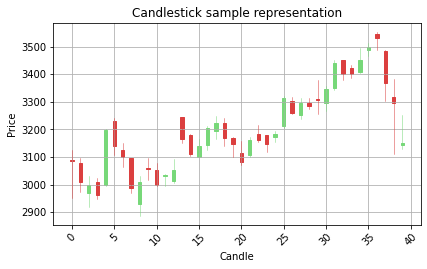

[0.71925336]
Correct trend is Bullish
Model prediction trend is Bullish
WON


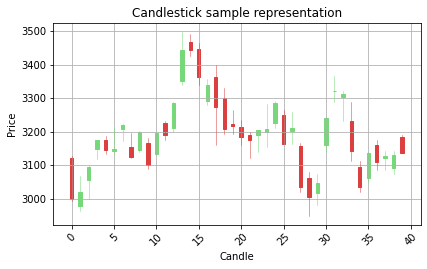

[0.4861255]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


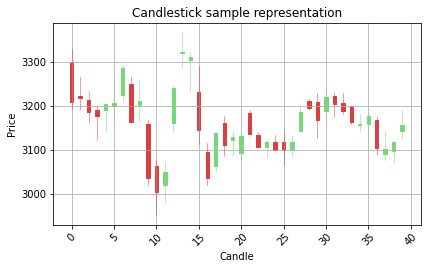

[0.16357297]
Correct trend is Bullish
Model prediction trend is Bearish
LOST


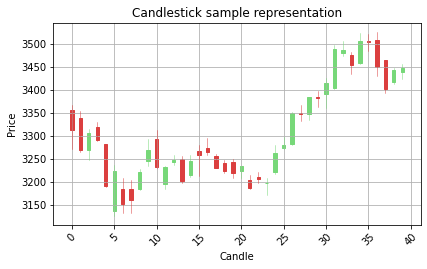

Won: 22 Lost: 17
Success rate: 56.41%


In [18]:

counter = 0
won = 0
lost = 0
bullish_counter = 0
bearish_counter = 0
test = model.predict(X_test)
alpha_distance = 0.5

for a in test:
    print(a)
    if a > (1-alpha_distance) or a < alpha_distance :
        if Y_test[counter] == 1:
            print('Correct trend is Bullish')
            bullish_counter = bullish_counter + 1
        if Y_test[counter] == 0:
            print('Correct trend is Bearish')
            bearish_counter = bearish_counter + 1
        if a > (1-alpha_distance):print('Model prediction trend is Bullish')
        if a < alpha_distance:print('Model prediction trend is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        d_arr = np.empty(( 0 ,4))

        d_arr = np.append(d_arr , X_test_raw[counter] , axis= 0 )
        

        graph_data_ohlc(d_arr)

    counter=counter+1
    
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')


In [19]:
bearish_counter / ( bullish_counter + bearish_counter)

0.4358974358974359